In [1]:
# Connect GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SENTIMENT ANALYSIS USING LOGISTIC REGRESSION
This project focuses on analyzing customer reviews from Amazon to gain insights into sentiment and emotional tendencies. Leveraging natural language processing (NLP) techniques and machine learning, a Logistic Regression model was developed to classify reviews into positive or negative sentiments. The project also explores aspect-based sentiment analysis and emotion detection, providing a comprehensive understanding of customer feedback to improve services or products.

In [94]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### INITIAL DATA EXPLORATION

Data Source: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews

The dataset of Amazon reviews was loaded and downsized to 3000 samples for streamlined processing. Columns were labeled as Polarity, Title, and Text to clarify their content. Missing values were checked and unique polarity values were inspected to ensure proper sentiment labels (1 for Negative, 2 for Positive).

In [97]:
# Load Dataset
data = pd.read_csv('amazon-reviews-train.csv', header=None)
data.head(3)

,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...


In [98]:
# Downsize the Dataset
data = data.sample(3000)
data.shape

(3000, 3)

In [99]:
# Assign Column Names
data.columns = ["Polarity","Title", "Text"]
data.head(3)

,Polarity,Title,Text
1541921,2,Portability for a heavy welder,I purchased this for a Hobart Champion 4500. I...
160615,2,Pretty Pleased,The album is actually a lot more than I expect...
2374410,1,Yawwwwnnnnnnnn!,I just wasted over an hour of my life. I want ...


Polarity: Indicates the sentiment of the review. 1: Negative review. 2: Positive review.  
Title: The heading of the review provided by the customer.  
Text: The detailed body of the review provided by the customer.  

In [100]:
# Dataset Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 1541921 to 2666392
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Polarity  3000 non-null   int64 
 1   Title     3000 non-null   object
 2   Text      3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.8+ KB


In [101]:
# Missing Values
data.isnull().sum()

,0
Polarity,0
Title,0
Text,0


#### DISTRIBURION OF POLARITY
Visualizing the distribution of Polarity helps understand the balance of positive and negative reviews in the dataset.

In [116]:
data['Polarity'].unique()

array([2, 1])

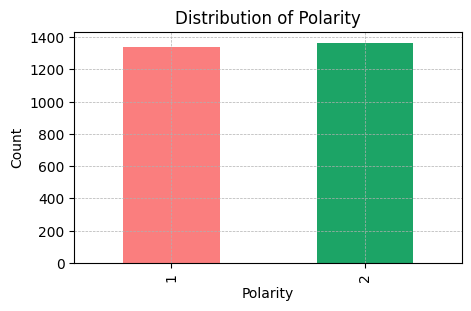

In [226]:
plt.figure(figsize=(5, 3))
data['Polarity'].value_counts().sort_index().plot(kind='bar', color=['#fa7e7e', '#1ca466'])
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

> The dataset is nearly balanced, with a comparable number of positive (2) and negative (1) reviews. This ensures that the analysis is not biased toward one sentiment class.



#### DISTRIBUTION OF REVIEW LENGTH
Analyzing the distribution of review lengths helps identify patterns in customer reviews. This step ensures that the text data is within a reasonable range for processing.

In [118]:
# Combine the Title and Text
data['Review'] = data['Title'] + ' ' + data['Text']

In [119]:
# Calculate Review Lengths
data['Review_Length'] = data['Review'].apply(len)

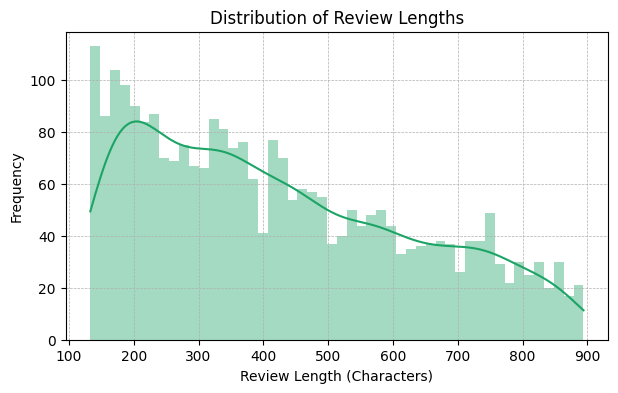

In [225]:
# Distribution of Review Lengths
plt.figure(figsize=(7, 4))
sns.histplot(data['Review_Length'], bins=50, kde=True, color='#1ca466', edgecolor=None, alpha=0.4)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

The distribution shows that most reviews are between 100 and 400 characters, with a gradual decline for longer reviews. This pattern suggests that customers tend to write concise feedback, with fewer extremely long reviews present.

In [121]:
# Statistics of Review Length
data['Review_Length'].describe()

,Review_Length
count,3000.000000
mean,433.676333
std,238.613661
min,100.000000
25%,228.000000
50%,382.500000
75%,600.250000
max,1014.000000


### HANDLING OUTLIERS IN REVIEW LENGTH
Boxplots are used to identify outliers in review lengths. Removing outliers ensures the data is consistent and avoids skewing analysis results.

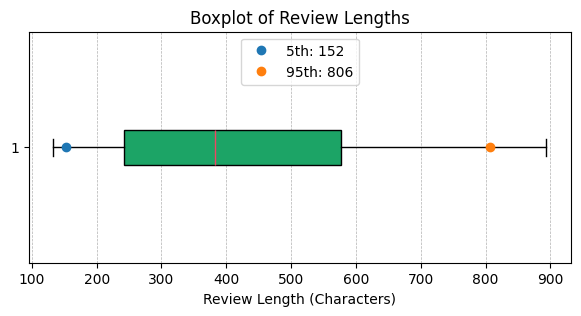

In [224]:
# Boxplot to visualize review length distribution before handling outliers
plt.figure(figsize=(7, 3))
plt.boxplot(data['Review_Length'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='#1ca466'), medianprops=dict(color='#f04562'))
plt.title('Boxplot of Review Lengths')
plt.xlabel('Review Length (Characters)')
plt.grid(axis='x', linestyle='--', linewidth=0.5)

# Annotate key percentiles with markers
percentiles = {
    '5th': data['Review_Length'].quantile(0.05),
    '95th': data['Review_Length'].quantile(0.95)
}
for label, value in percentiles.items():
    plt.plot(value, 1, 'o', label=f'{label}: {int(value)}')
plt.legend(loc='upper center')
plt.show()

The boxplot identifies outliers in review lengths. Reviews shorter than the 5th percentile (133 characters) and longer than the 95th percentile (894 characters) should be removed. This step results in a cleaner dataset, improving the reliability of further analyses.

In [123]:
# Handle outliers by removing entries outside the 5th and 95th percentiles
lower_limit = data['Review_Length'].quantile(0.05)
upper_limit = data['Review_Length'].quantile(0.95)
# Remove Outliers
data = data[(data['Review_Length'] >= lower_limit) & (data['Review_Length'] <= upper_limit)]
data.shape

(2703, 5)



> The updated dataset now contains 2703 entries within the range between 133 and 894 characters.



### TEXT PREPROCESSING
Preprocessing text is a crucial step to prepare the data for sentiment analysis and emotion detection. By cleaning the text means removing noise, standardizing input, and improving the performance of machine learning models.

Non-alphabetic characters and numbers are removed to keep only meaningful words. All text is converted to lowercase to ensure consistency and avoid case sensitivity issues. Tokenization breaks the text into individual words for easier analysis. Stopwords (like "the" and "is") are removed because they don't add much meaning to the context. Lemmatization simplifies words to their base form (e.g., "running" becomes "run") to group similar terms together. These steps improve the quality of the text data and make it ready for better analysis.

In [124]:
# Import NLTK Functions
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [30]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [125]:
# Define Text Preprocess Steps

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back to a single string
    return ' '.join(tokens)

In [126]:
# Apply preprocessing to the Text column
data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

<ipython-input-126-5102cf5453c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cleaned_Review'] = data['Review'].apply(preprocess_text)


In [33]:
data[['Review', 'Cleaned_Review']].head()

,Review,Cleaned_Review
442176,The Flame Still Burns for this bloomin' brilli...,flame still burn bloomin brilliant movie amazi...
3447785,Clear and Incisive Zen Master Dae Gak writes w...,clear incisive zen master dae gak writes carit...
1316863,A Fabulous CD!!!! Celine Dion is incredible. S...,fabulous cd celine dion incredible beautiful v...
2920478,AOK with me Didn't want to pay Monster prices ...,aok want pay monster price apparently mind pay...
2128425,Great peek into what living with multiple (and...,great peek living multiple unusual animal like...


#### ASPECT BASED SENTIMENT ANALYSIS
Analyzing sentiment for specific aspects such as product, delivery, and service helps gain deeper insights into customer feedback. Reviews are divided into positive and negative sentiments based on the Polarity column. Key aspects like product, delivery, and service are identified. For each aspect, positive and negative mentions are counted. The sentiment distribution for each aspect is visualized using a stacked bar chart.

In [127]:
# Split data into positive and negative sentiment reviews
data_positive = data[data['Polarity'] == 2]  # Assuming 2 is for positive sentiment
data_negative = data[data['Polarity'] == 1]  # Assuming 1 is for negative sentiment

In [128]:
# Define aspects of interest
aspects = ['product', 'delivery', 'service', 'price', 'quality']
# Create a list to store aspect-level sentiment counts
aspect_sentiment = []
for aspect in aspects:
    # Filter reviews mentioning the aspect
    aspect_positive = data_positive[data_positive['Cleaned_Review'].str.contains(aspect, case=False, na=False)]
    aspect_negative = data_negative[data_negative['Cleaned_Review'].str.contains(aspect, case=False, na=False)]
    # Count sentiments for the aspect
    aspect_sentiment.append({
        'Aspect': aspect,
        'Positive': len(aspect_positive),
        'Negative': len(aspect_negative)
    })
# Convert the list to a DataFrame
aspect_sentiment_df = pd.DataFrame(aspect_sentiment)
aspect_sentiment_df

,Aspect,Positive,Negative
0,product,123,178
1,delivery,10,5
2,service,20,30
3,price,86,53
4,quality,67,102


In [129]:
# Calculate percentages
aspect_sentiment_df['Total'] = aspect_sentiment_df['Positive'] + aspect_sentiment_df['Negative']
aspect_sentiment_df['Positive %'] = (aspect_sentiment_df['Positive'] / aspect_sentiment_df['Total']) * 100
aspect_sentiment_df['Negative %'] = (aspect_sentiment_df['Negative'] / aspect_sentiment_df['Total']) * 100

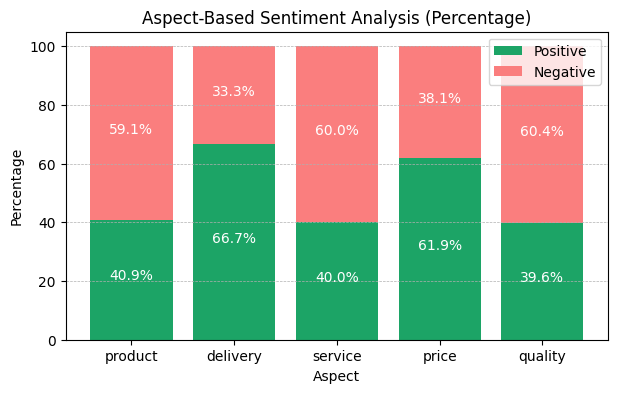

In [223]:
# Visualize aspect-level sentiment as a stacked bar chart (in percentages)
fig, ax = plt.subplots(figsize=(7, 4))
x = aspect_sentiment_df['Aspect']

# Plot Positive and Negative bars
ax.bar(x, aspect_sentiment_df['Positive %'], label='Positive', color='#1ca466')
ax.bar(x, aspect_sentiment_df['Negative %'], bottom=aspect_sentiment_df['Positive %'], label='Negative', color='#fa7e7e')

# Add percentage labels
for i, row in aspect_sentiment_df.iterrows():
    ax.text(i, row['Positive %'] / 2, f"{row['Positive %']:.1f}%", ha='center', color='white', fontsize=10)
    ax.text(i, row['Positive %'] + row['Negative %'] / 2, f"{row['Negative %']:.1f}%", ha='center', color='white', fontsize=10)

plt.title('Aspect-Based Sentiment Analysis (Percentage)')
plt.ylabel('Percentage')
plt.xlabel('Aspect')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(['Positive', 'Negative'], loc='upper right')
plt.show()



> The aspect-based sentiment analysis shows that Delivery and Price aspects have higher positive sentiment, with 66.7% and 61.9% positive reviews, respectively, indicating strong customer satisfaction in these areas. However, aspects like Product and Quality show significant dissatisfaction, with 59.1% and 60.4% negative feedback, respectively. Service also reflects a negative trend at 60.0%, highlighting key areas for potential improvement.



#### EMOTION DETECTION
Emotion detection identifies the dominant emotions expressed in customer reviews, providing deeper insights into customer sentiments.
Each review is processed using NRCLex to calculate scores for various emotions. The emotion with the highest score is assigned as the dominant emotion for each review. A bar chart is used to visualize the frequency distribution of dominant emotions.

In [138]:
from nrclex import NRCLex

# Emotion Detection Using NRCLex
def detect_emotions(text):
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

In [140]:
# Apply emotion detection to the dataset
data['Emotion_Scores'] = data['Review'].apply(detect_emotions)

<ipython-input-140-e3129d06702c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Emotion_Scores'] = data['Review'].apply(detect_emotions)


In [141]:
# Find the dominant emotion for each review
def get_dominant_emotion(emotion_scores):
    if emotion_scores:
        return max(emotion_scores, key=emotion_scores.get)
    return "Neutral"

In [142]:
data['Dominant_Emotion'] = data['Emotion_Scores'].apply(get_dominant_emotion)

<ipython-input-142-b347f0fe6b7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dominant_Emotion'] = data['Emotion_Scores'].apply(get_dominant_emotion)


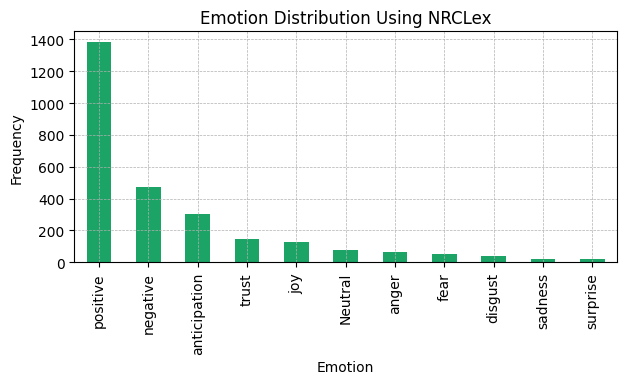

In [222]:
# Visualize the distribution of dominant emotions
emotion_counts = data['Dominant_Emotion'].value_counts()
emotion_counts.plot(kind='bar', color='#1ca466', figsize=(7, 3))
plt.title('Emotion Distribution Using NRCLex')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.grid(axis='both', linestyle='--', linewidth=0.5)
plt.show()



> The emotion distribution reveals that Positive is the dominant emotion, appearing in nearly 1400 reviews, followed by Negative at around 500 reviews. Anticipation and Trust appeared moderately. Emotions like Anger, Sadness, and Disgust are minimal, indicating reviews are generally constructive with some dissatisfaction.



#### LOGISTIC REGRESSION MODEL
A Logistic Regression model is developed to classify reviews into positive or negative sentiment using TF-IDF vectorization.  
  
TF-IDF Vectorization converts the cleaned text into numerical features, capturing term importance. Data splitting divides the dataset into training and testing sets. Model training fits the Logistic Regression model on the training data. The model's performance is evaluated using accuracy.

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['Cleaned_Review'])

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [174]:
# Prepare labels (Polarity) and split the data
y = data['Polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [175]:
# Train a Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [176]:
# Make predictions
y_pred = log_reg.predict(X_test)

In [205]:
# Evaluate the model
accuracy_score(y_test, y_pred)

0.8243992606284658



> The Logistic Regression model achieves an accuracy of 82%, indicating strong performance in distinguishing between positive and negative reviews. This result highlights the effectiveness of combining TF-IDF features with Logistic Regression for sentiment analysis.



##### Confusion Matrix
To further analyze the model's performance, a confusion matrix was plotted to show the distribution of true positive, true negative, false positive, and false negative predictions.

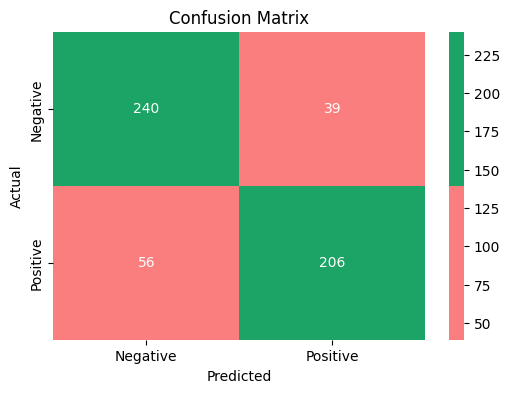

In [221]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=['#fa7e7e', '#1ca466'], xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix shows that the model correctly identified 240 negative reviews and 206 positive reviews. However, it inaccurately predicted 39 negative reviews as positive and 56 positive reviews as negative. This analysis provides a clear understanding of the model's strengths and weaknesses in sentiment classification.

#### LIVE SENTIMENT PREDICTION DEMO

This function is developed to recheck the model by predicting sentiment (Positive or Negative) for given review titles and descriptions.

In [76]:
# Function for live demo
def predict_sentiment(review, title):
    # Preprocess the input review and title
    cleaned_review = preprocess_text(review)
    cleaned_title = preprocess_text(title)
    combined = cleaned_title + ' ' + cleaned_review
    # Vectorize the combined input
    vectorized_review = tfidf_vectorizer.transform([combined])
    # Predict sentiment
    prediction = log_reg.predict(vectorized_review)
    sentiment = "Positive" if prediction[0] == 2 else "Negative"
    return sentiment

In [78]:
# Demo
print("\n--- Sentiment Prediction Demo ---")
demo_examples = [
    {"title": "Great Service", "review": "The staff was helpful and the service was excellent."},
    {"title": "Poor Quality", "review": "The product broke after one use, very disappointed."},
    {"title": "Fast Delivery", "review": "The package arrived much earlier than expected, great experience!"},
    {"title": "Not Worth the Money", "review": "The item was overpriced and did not meet my expectations."},
    {"title": "Do not Buy!", "review": "Poor quality and disppointed on customer support!"}
]

for example in demo_examples:
    title = example['title']
    review = example['review']
    print(f"\nTitle: {title}")
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {predict_sentiment(review, title)}")


--- Sentiment Prediction Demo ---

Title: Great Service
Review: The staff was helpful and the service was excellent.
Predicted Sentiment: Positive

Title: Poor Quality
Review: The product broke after one use, very disappointed.
Predicted Sentiment: Negative

Title: Fast Delivery
Review: The package arrived much earlier than expected, great experience!
Predicted Sentiment: Positive

Title: Not Worth the Money
Review: The item was overpriced and did not meet my expectations.
Predicted Sentiment: Negative

Title: Do not Buy!
Review: Poor quality and disppointed on customer support!
Predicted Sentiment: Negative


### CONCLUSION
By developing a Logistic Regression model with an accuracy of 82%, sentiment classification was achieved effectively. Additionally, aspect-based sentiment analysis and emotion detection provided deeper insights into customer feedback. The live demo feature further validated the model's performance, showcasing its applicability in real-world scenarios.